In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

**州**

CA、TX、WI

**店铺**

CA_1、CA_2、CA_3、CA_4

**品类**

HOBBIES、FOOLDS、HOUSEHOLD

**部门**

HOBBIES_1、HOBBIES_2

**具体商品**

HOBBIES_1_001、HOBBIES_1_002

In [3]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

In [4]:
# sales.head()

In [5]:
# sales.tail()

In [6]:
# sales.info()

In [7]:
# sale1 = sales[['id','item_id','dept_id','cat_id','store_id','state_id']]

In [8]:
# sale1.info()

In [9]:
# a = list(sale1['state_id'].unique())
# b = len(a)
# b

In [10]:
# sale1.describe()

In [11]:
# calendar.head(15)

In [12]:
# calendar['event_name_1'].unique()

In [13]:
# calendar['event_type_1'].unique()

In [14]:
# calendar['event_name_2'].unique()

In [15]:
# calendar['event_type_2'].unique()

In [16]:
# calendar['wm_yr_wk'].unique()

In [17]:
# prices.head(10)

In [18]:
# calendar.info()

In [19]:
# prices.info()

In [20]:
# calendar.isnull().sum()/len(calendar)

In [21]:
# calendar.isnull().sum()

In [22]:
# calendar1 = calendar[['wm_yr_wk','wday','month','year','snap_CA','snap_TX','snap_WI']]
# calendar.describe()

In [23]:
# calendar1

In [24]:
# a = list(prices['sell_price'].unique())
# b = len(a)
# b

In [25]:
# prices['wm_yr_wk'].count()

In [26]:
# calendar1[calendar1.snap_TX==1].count()

In [27]:
# prices.info()

In [28]:
# sales.isnull().sum().sort_values(ascending=False)

In [29]:
# calendar.isnull().sum().sort_values(ascending=False)

In [30]:
# prices.isnull().sum().sort_values(ascending=False)

# **缺失值**
* event_type_2    0.997461
* event_name_2    0.997461
* event_type_1    0.917725
* event_name_1    0.917725


In [31]:
# calendar.isnull().sum().sort_values(ascending=False)/len(calendar)

#  **查看单件商品销售趋势**

In [32]:
# # 选取sales中第一列，查看HOBBIES_1_001从第1天到第1941天销量
# oneProduct = pd.DataFrame(sales.drop(['id','item_id','dept_id','cat_id','store_id','state_id'],axis=1).loc[0])
# oneProduct.columns = ['sales']
# plt.figure(figsize=(15,8))
# plt.plot([x for x in range(1941)],oneProduct['sales'])

In [33]:
# #FOODS_3_825
# anotherProduct = pd.DataFrame(sales.drop(['id','item_id','dept_id','cat_id','store_id','state_id'],axis=1).loc[30487])
# anotherProduct.columns = ['sales']
# plt.figure(figsize=(15,8))
# plt.plot([x for x in range(1941)],anotherProduct['sales'])

# 查看整体聚合销量时间序列
可以看到基本呈一个上升趋势，同时存在一定的周期性，会在某一天突然下降（猜测是圣诞节）

In [34]:
# allstore = sales.drop(['id','item_id','dept_id','cat_id','store_id','state_id'],axis=1).sum()
# allstore.index=  calendar['date'].head(1941)
# allstore.transpose().plot(figsize=(15,10));

In [35]:
# # 在平均滚动值为7的情况下，查看整体销售时间序列
# allstore.transpose().rolling(window=7).mean().plot(figsize=(15,10));

# 每个类别的时间序列

In [36]:
# cat_agg =sales.drop(['id','item_id','dept_id','store_id','state_id'],axis=1).groupby('cat_id').sum()
# cat_agg.columns=  calendar['date'].head(1941)
# cat_agg.transpose().plot(figsize=(10,7));

In [37]:
# cat_agg.transpose().rolling(window=7).mean().plot(figsize=(10,7));

# 每个店铺的时间序列

In [38]:
# store_agg = sales.drop(['id','item_id','dept_id','state_id','cat_id'],axis=1).groupby('store_id').sum()
# store_agg.columns=  calendar['date'].head(1941)
# store_agg.transpose().plot(figsize=(12,8));

In [39]:
# store_agg.transpose().rolling(window=7).mean().plot(figsize=(12,8));

# 每个州的时间序列

In [40]:
# store_agg = sales.drop(['id','item_id','dept_id','store_id','cat_id'],axis=1).groupby('state_id').sum()
# store_agg.columns=  calendar['date'].head(1941)
# store_agg.transpose().plot(figsize=(10,7));

In [41]:
# store_agg.transpose().rolling(window=7).mean().plot(figsize=(12,8));

In [42]:
# store_agg = sales.drop(['id','item_id','store_id','state_id','cat_id'],axis=1).groupby('dept_id').sum()
# store_agg.columns=  calendar['date'].head(1941)
# store_agg.transpose().plot(figsize=(10,7));

In [43]:
# store_agg.transpose().rolling(window=7).mean().plot(figsize=(12,8));

In [44]:
# store_agg = sales.drop(['id','item_id','store_id','dept_id'],axis=1).groupby(['state_id','cat_id']).sum()
# store_agg.columns=  calendar['date'].head(1941)
# store_agg.transpose().plot(figsize=(12,8));

In [45]:
# store_agg.transpose().rolling(window=7).mean().plot(figsize=(12,8));

In [46]:
# # 引入gc模块进行垃圾回收
# import gc
# del store_agg,cat_agg,allstore,anotherProduct,oneProduct
# gc.collect()

In [47]:
# del sale1
# gc.collect()

In [48]:
#引入warning模块，在向下转换成int和float时，减少数据帧的内存使用量，以避免内存错误（即下面的downcast函数）
import warnings 
warnings.filterwarnings('ignore')

In [49]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [50]:
# sales

In [51]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [52]:
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [53]:
# sale1 = sales[['id','item_id','dept_id','cat_id','store_id','state_id','d_1']]

In [54]:
# sale1.info()

In [55]:
# calendar.info()

In [56]:
# prices.info()

In [57]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [58]:
del sales, prices, calendar
gc.collect()

20

In [59]:
# df

In [60]:
# df['sold'].unique()

In [61]:
# df.info()

In [62]:
# 将id item_id dept_id cat_id store_id state_id加入字典中,最后生成submission时会用到
d_id = dict(zip(df.id.cat.codes, df.id))
# d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
# d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
# d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
# d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [63]:
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))

In [64]:
# d_id

# 缺失值处理&数据预处理

In [65]:
#类别变量编码
list1=['event_name_1','event_type_1','event_name_2','event_type_2']
for i in list1:
    df[i] = df[i].cat.add_categories("nan").fillna("nan")
    df[i]=LabelEncoder().fit_transform(df[i]).astype(np.int8)
    df[i]=df[i].astype('category')

In [66]:
# df['event_type_1']

In [67]:
#日期类型转换
# d_1 经过拆分变成d和1，仅保留1
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

In [68]:
# df['d']

In [69]:
#类别变量类型转换
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

In [70]:
# df['event_type_1']

In [71]:
# 转换为日期类型
# 因为df中已经存在了year和month字段，但是没有day字段，只有wday（星期几）,所以对date字段进行一下处理，只保留最后的数字即可（即2011-1-29保留29）
df['date'] = df['date'].apply(lambda x: x.strftime('%d')).astype(np.int8)

In [72]:
# df['date'].head()

# 特征工程

**滞后特征的创建**

In [73]:
lags = [28,35,42,49]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [74]:
# df['sold_lag_35'].unique()

In [75]:
# df.info()

In [76]:
lags2 = [1,2]
for lag in lags2:
    df['event1_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['event_name_1'].shift(lag).astype(np.float16)
    df['event1_lag_'+str(lag)].fillna(100, inplace=True)
    df['event1_lag_'+str(lag)]=df['event1_lag_'+str(lag)].astype(np.int8)
    df['event1_lag_'+str(lag)]=df['event1_lag_'+str(lag)].astype('category')

**其他特征的创建**
* 平均值
* 更新字段
* 删除部分不必要的特征

In [77]:
df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)    
#df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
#df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
#df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
#df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [78]:
df['wm_yr_wk_linear']=LabelEncoder().fit_transform(df['wm_yr_wk'].values).astype(np.int16)
df.drop(['wm_yr_wk'], axis=1, inplace=True)

In [79]:
df['price_lag'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sell_price'].shift(7).astype(np.float16)
df['price-diff']=df['price_lag']-df['sell_price']
df.drop(['price_lag'], axis=1, inplace=True)

In [80]:
df['sell_price'].fillna(-1,inplace=True)
df['decimal']=df['sell_price'].apply(lambda x: 100*(x-int(x))).astype(np.int16)
df['sell_price'].replace(-1,np.nan,inplace=True)

In [81]:
df['expanding_price_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sell_price'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
df['diff_moving_mean']=df['expanding_price_mean']-df['sell_price']
df.drop(['expanding_price_mean'], axis=1, inplace=True)

In [82]:
df['price-diff']=df['price-diff'].astype(np.float16)
df.drop(['wday'], axis=1, inplace=True)
df['decimal']=df['decimal'].astype(np.int8)
df['year']=LabelEncoder().fit_transform(df['year']).astype(np.int8)

In [83]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sell_price'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sell_price'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [84]:
df['price_max'] = df.groupby(['store_id','item_id'])['sell_price'].transform('max')
#df['price_min'] = df.groupby(['store_id','item_id'])['sell_price'].transform('min')
#df['price_std'] = df.groupby(['store_id','item_id'])['sell_price'].transform('std')
#df['price_mean'] = df.groupby(['store_id','item_id'])['sell_price'].transform('mean')
df['price_norm'] = df['sell_price']/df['price_max']
#df['price_momentum'] = df['sell_price']/df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
df['price_momentum_m'] = df['sell_price']/df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
df['price_momentum_y'] = df['sell_price']/df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

In [85]:
#df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
#df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
#df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
#df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
#df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
#df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [86]:
#删除不必要的列
list3=['cat_id','state_id']
for i in list3:
    df.drop([i], axis=1, inplace=True)

In [87]:
#将数据框另存为pkl
#由于df的数据量过于庞大，之后进行建模有可能会导致程序崩溃，所以先将df存为pkl文件
df = df[df['d']>=49]
df.to_pickle('data.pkl')
del df
gc.collect()

148

In [98]:
#剪切测试数据
data = pd.read_pickle('data.pkl')
valid_csv=data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds_csv=valid_csv['sold']

In [99]:
#存储分类变量

cat_column=[]
for i in data.columns:
    if(str(data.dtypes[i])=='category'):
        cat_column.append(i)

In [100]:
#通过store_id建模

for store in d_store_id:
    df = data[data['store_id']==store]
    
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid_csv, y_valid_csv = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    model = LGBMRegressor(
        learning_rate= 0.05,
        subsample=0.6,
        feature_fraction=0.6,
        num_iterations = 1200,
        max_bin=350,
        num_leaves= 300,
        lambda_l2=0.003,
        max_depth=200,
        min_data_in_leaf= 80,
        force_row_wise= True,
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid_csv,y_valid_csv)],
             eval_metric='rmse',  verbose=100, early_stopping_rounds=20,categorical_feature=cat_column)
    valid_preds_csv[X_valid_csv.index] = model.predict(X_valid_csv)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'

    #保存模型
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid_csv, y_valid_csv
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 2.26638	training's l2: 5.13646	valid_1's rmse: 2.2513	valid_1's l2: 5.06836
Early stopping, best iteration is:
[161]	training's rmse: 2.18946	training's l2: 4.79376	valid_1's rmse: 2.23993	valid_1's l2: 5.01728
*****Prediction for Store: CA_2*****
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1.7765	training's l2: 3.15595	valid_1's rmse: 2.07663	valid_1's l2: 4.3124
[200]	training's rmse: 1.71017	training's l2: 2.92467	valid_1's rmse: 2.0631	valid_1's l2: 4.25638
[300]	training's rmse: 1.66994	training's l2: 2.7887	valid_1's rmse: 2.05743	valid_1's l2: 4.23302
Early stopping, best iteration is:
[310]	training's rmse: 1.66636	training's l2: 2.77675	valid_1's rmse: 2.05702	valid_1's l2: 4.23131
*****Prediction for Store: CA_3*****
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 3.10883	training's

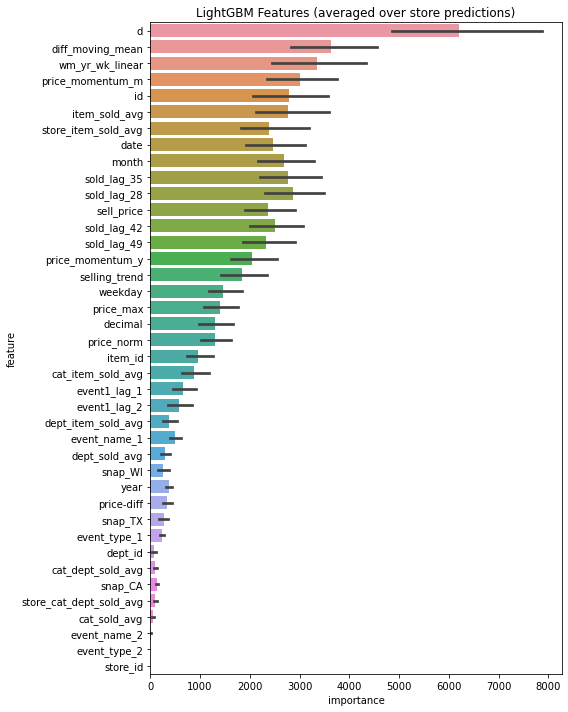

In [101]:
#特征重要性的计算和可视化

feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('/kaggle/working/'):
    if 'model' in filename:
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [102]:
valid_csv['sold'] = valid_preds_csv
validation = valid_csv[['id','d','sold']]
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.id = evaluation.id.map(d_id)

#创建提交文件
submit = pd.concat([validation,evaluation]).reset_index(drop=True)


for i in range(1,29):
    submit['F'+str(i)] *= 1.04

submit.to_csv('submission.csv',index=False)